1. Download Data, model and Preprocessing

In [ ]:
!gdown --id '1nnCAtnAdSBAyw22JJVqArZHApBfW5vvo'

In [ ]:
!unzip 'round2_test.zip'

In [ ]:
!gdown --id '1n3BpG0glA_jgBQLyi3jKE4tlBTi2l83B'

In [ ]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

In [8]:
import torch
from models.common import DetectMultiBackend
from utils.general import non_max_suppression, scale_boxes
from utils.torch_utils import select_device, smart_inference_mode
import cv2  # Import OpenCV
import numpy as np  # Ensure numpy is imported

# Correctly placed letterbox function
def letterbox(img, new_shape=(640, 640), color=(0, 0, 0)):
    """Resize image to a 32-pixel-multiple rectangle"""
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # width, height deltas
    dw, dh = np.mod(dw, 64), np.mod(dh, 64)  # divide padding into 2 sides
    dw /= 2
    dh /= 2
    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = round(dh - 0.1), round(dh + 0.1)
    left, right = round(dw - 0.1), round(dw + 0.1)
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img

@smart_inference_mode()
def run_object_detection_video(weights='/content/best_workout_4.pt',
                               source='/content/data_mae/train/lateral raise/lateral_raise_6.MOV',
                               imgsz=(640, 640),
                               conf_thres=0.5,
                               iou_thres=0.5,
                               device='0',
                               classes=None,
                               agnostic_nms=False):
    # Setup
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, dnn=False)

    # Video capture
    vid_cap = cv2.VideoCapture(source)
    assert vid_cap.isOpened(), f'Failed to open video {source}'

    # List to store detections for each frame, including the frame number
    frame_detections = []

    frame_number = 0  # Initialize frame counter

    total_frames = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    original_fps = vid_cap.get(cv2.CAP_PROP_FPS)
    duration = total_frames / original_fps
    # Tính toán phần trăm và thời điểm bắt đầu, kết thúc để cắt
    if duration > 60:
        start_percent = 15
        end_percent = 85
    elif duration > 10:
        start_percent = 10
        end_percent = 90
    else:
        start_percent = 0
        end_percent = 100

    start_frame = int((start_percent / 100) * total_frames)
    end_frame = int((end_percent / 100) * total_frames)
    current_frame = 0
    # Process each frame
    while True:
        ret, frame = vid_cap.read()
        current_frame+=1
        if not ret:
            break
        if start_frame <= current_frame <= end_frame:
            # Convert BGR (OpenCV format) to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Resize and pad frame to model input size
            img = letterbox(frame, new_shape=imgsz)
            img = img.transpose((2, 0, 1))  # HWC to CHW
            img = np.ascontiguousarray(img)

            img = torch.from_numpy(img).to(device).float() / 255.0
            img = img[None]  # add batch dimension

            pred = model(img, augment=False, visualize=False)
            pred = non_max_suppression(pred, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)

            detections = []
            for i, det in enumerate(pred):  # detections per frame
                if len(det):
                    det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], frame.shape).round()

                    for *xyxy, conf, cls in reversed(det):
                        bbox = tuple(c.item() for c in xyxy)  # Convert bbox coordinates to tuple of floats
                        # Now including frame_number in the detection information
                        detections.append((cls.item(), conf.item(), bbox, current_frame))

            if detections:  # If there are detections in the current frame
                frame_detections.append(detections)

    vid_cap.release()
    return frame_detections

In [9]:
import cv2

def crop_and_resize_frames(input_video_path, output_video_path, predictions):
    # Mở video gốc
    cap = cv2.VideoCapture(input_video_path)

    # Lấy thông số frame rate và định dạng size của video
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (224, 224))
    frame_id = 1
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if 1:
            largest_bbox = None
            max_area = 0
            for pred in predictions:
                if pred[0][3] == frame_id:  # Kiểm tra frame_id của prediction
                    _, _, bbox, _ = pred[0]
                    x_min, y_min, x_max, y_max = bbox
                    area = (x_max - x_min) * (y_max - y_min)
                    if area > max_area:
                        max_area = area
                        largest_bbox = bbox
            if largest_bbox is not None:
                x_min, y_min, x_max, y_max = largest_bbox
                cropped_frame = frame[int(y_min):int(y_max), int(x_min):int(x_max)]
            else:
                # Nếu không có bbox, lấy toàn bộ khung hình
                cropped_frame = frame

            # Resize khung hình về 224x224
            resized_frame = cv2.resize(cropped_frame, (224, 224))

            # Viết frame đã chỉnh sửa vào file output
            out.write(resized_frame)

        frame_id += 1

    # Giải phóng và đóng tất cả
    cap.release()
    out.release()

In [10]:
import os

data_dir = "/content/content/drive/MyDrive/AI4LIFE2024-DATA/Test - Vòng loại"
output_dir = "/content/ss4"
from pathlib import Path; Path(output_dir).mkdir(parents=True, exist_ok=True)
for video_file in os.listdir(data_dir):
            input_video_path = os.path.join(data_dir, video_file)
            filename_without_extension, _ = os.path.splitext(video_file)
            output_video_path = f"{output_dir}/{filename_without_extension}.mp4"
            print(filename_without_extension)
            video_detections = run_object_detection_video(source=input_video_path)
            crop_and_resize_frames(input_video_path, output_video_path, video_detections)

YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



pull up_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



push-up_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



squat_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



tricep dips_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



shoulder press_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



lat pulldown_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



chest fly machine_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



plank_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



pull up_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



russian twist_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



romanian deadlift_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



leg raises_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



russian twist_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



hip thrush_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



chest fly machine_3


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



chest fly machine_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



incline bench press_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



leg raises_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



tricep pushdown_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



sholder press_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



lat pulldown_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



bench press_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



incline bench press_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



t bat row_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



deadlift_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



romanian deadlift_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



hip thrust_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



barbell biceps curl_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



decline bench press_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



tricep dips_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



hammer curl_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



leg extension_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



t bar row_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



hammer curl_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



lateral raise_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



declince bench press_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



leg extension_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



squat_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



bench press_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs


In [11]:
cd '/content'

/content


In [12]:
import os

# Root directory name
root_dir = "Workout_Exercises"

# List of exercises - directory names
exercises = [
    "barbell biceps curl", "bench press", "chest fly machine", "dbp",
    "deadlift", "hammer curl", "hip thrust", "incline bench press",
    "lat pulldown", "lateral raise", "leg extension", "leg raises",
    "plank", "pull up", "push-up", "romanian deadlift", "russian twist",
    "shoulder press", "squat", "t bar row", "tricep dips", "tricep pushdown"
]

# Create root directory
os.makedirs(root_dir, exist_ok=True)

# Create each exercise directory within the root directory
for exercise in exercises:
    os.makedirs(os.path.join(root_dir, exercise), exist_ok=True)

"Directories created successfully."

'Directories created successfully.'

In [ ]:
import os
import shutil

# Đường dẫn đến thư mục chứa video và thư mục đích
source_dir = 'ss4'
destination_dir = 'Workout_Exercises'

# Lấy danh sách tất cả các video trong thư mục nguồn
videos = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

# Lấy danh sách tất cả các thư mục con trong thư mục đích
subdirectories = [d for d in os.listdir(destination_dir) if os.path.isdir(os.path.join(destination_dir, d))]

# Đảm bảo số video phải nhiều hơn số thư mục con
if len(videos) > len(subdirectories):
    # Phân phối video đến các thư mục con
    for i, video in enumerate(videos):
        destination_subdir = os.path.join(destination_dir, subdirectories[i % len(subdirectories)])
        source_video_path = os.path.join(source_dir, video)
        destination_video_path = os.path.join(destination_subdir, video)

        # Di chuyển video
        shutil.move(source_video_path, destination_video_path)
        print(f'Moved "{video}" to "{destination_subdir}"')
else:
    print("Số video phải nhiều hơn số thư mục con.")

In [ ]:
!pip install transformers datasets
!pip install -q pytorchvideo evaluate

In [ ]:
!pip install torchvision==0.14.1

In [2]:
import os

# Define the root directory of your dataset
dataset_root = '/content/Workout_Exercises'

# Initialize an empty list to store the paths of all video files
all_video_file_paths = []

# Walk through the directory structure
for root, dirs, files in os.walk(dataset_root):
    for file in files:
        # Check if the file is a video file by its extension (assuming .mp4)
        if 1:
            # Construct the full path of the file
            full_path = os.path.join(root, file)
            # Append the full path to the list
            all_video_file_paths.append(full_path)
print(all_video_file_paths)

['/content/Workout_Exercises/leg raises/pull up_1.mp4', '/content/Workout_Exercises/leg raises/incline bench press_2.mp4', '/content/Workout_Exercises/dbp/push-up_1.mp4', '/content/Workout_Exercises/dbp/t bat row_1.mp4', '/content/Workout_Exercises/plank/squat_2.mp4', '/content/Workout_Exercises/plank/deadlift_1.mp4', '/content/Workout_Exercises/squat/tricep dips_1.mp4', '/content/Workout_Exercises/squat/romanian deadlift_1.mp4', '/content/Workout_Exercises/russian twist/shoulder press_1.mp4', '/content/Workout_Exercises/russian twist/hip thrust_1.mp4', '/content/Workout_Exercises/leg extension/lat pulldown_2.mp4', '/content/Workout_Exercises/leg extension/barbell biceps curl_1.mp4', '/content/Workout_Exercises/hip thrust/chest fly machine_1.mp4', '/content/Workout_Exercises/hip thrust/decline bench press_2.mp4', '/content/Workout_Exercises/hammer curl/plank_1.mp4', '/content/Workout_Exercises/hammer curl/tricep dips_2.mp4', '/content/Workout_Exercises/lateral raise/pull up_2.mp4', '/c

In [3]:
class_labels = sorted({str(path).split("/")[-2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['barbell biceps curl', 'bench press', 'chest fly machine', 'dbp', 'deadlift', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raise', 'leg extension', 'leg raises', 'plank', 'pull up', 'push-up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown'].


In [4]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
    RandomAffine,
    ColorJitter
)

In [16]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "bluebird089/videomae-base-finetuned-kinetics-finetuned-round2-v4"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

preprocessor_config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/345M [00:00<?, ?B/s]

In [17]:
mean = image_processor.image_mean
std = image_processor.image_std

num_frames_to_sample = model.config.num_frames

clip_duration = 3

In [18]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize((224,224)),
                ]
            ),
        ),
    ]
)

import shutil
checkpoints_path = '/content/Workout_Exercises/.ipynb_checkpoints'
shutil.rmtree(checkpoints_path, ignore_errors=True)

# Now, you can load your dataset as before
test_dataset = pytorchvideo.data.Ucf101(
    data_path='/content/Workout_Exercises',
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [19]:
print(test_dataset.num_videos)

39


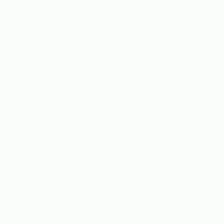

In [20]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 5}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(test_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

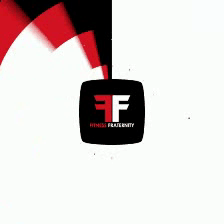

In [21]:
sample_test_video = next(iter(test_dataset))
video_tensor = sample_test_video["video"]
video_name = sample_test_video["video_name"]
video_label = id2label[sample_test_video["label"]]
display_gif(video_tensor)

In [22]:
videos = []
labels = []
video_names = []
for sample in test_dataset:
    video_tensor = sample["video"]
    video_label = id2label[sample["label"]]
    video_name = sample["video_name"]
    videos.append(video_tensor)
    labels.append(video_label)
    video_names.append(video_name)


In [23]:
import torch
def run_inference(model, video, label):
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)
    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        # "labels": torch.tensor(
        #     [label]
        # ),  # this can be skipped if you don't have labels available.
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [24]:
predicted = []
for index in range(len(videos)):
  logits = run_inference(model, videos[index], labels[index])
  predicted_class_idx = logits.argmax(-1).item()
  predicted.append(model.config.id2label[predicted_class_idx])

In [25]:
# Chuyển đổi list thành set để loại bỏ các phần tử trùng lặp
S = set(video_names)

print(S.__len__())


39


In [26]:
from collections import Counter
# List để lưu các id (vị trí) của phần tử từ S trong L
indices = []
predicted2 = []  # Danh sách nhãn dự đoán
actual_labels2 = []  # Danh sách nhãn thực tế
for item in S:
    try:
        # print(item)
        # Lặp qua từng phần tử của S và tìm id của nó trong L
        # Lưu ý: Vòng lặp dưới đây sẽ tìm tất cả các vị trí của item trong L
        indices = [i for i, x in enumerate(video_names) if x == item]
        # print(indices)
        values = [predicted[i] for i in indices]

        # Sử dụng Counter để thống kê và tìm giá trị xuất hiện nhiều nhất
        most_common_value, count = Counter(values).most_common(1)[0]

        print(f'Giá trị xuất hiện nhiều nhất là: {most_common_value} với {count}/{indices.__len__()} lần xuất hiện - label {item}')
        actual_labels2.append(labels[indices[0]])
        predicted2.append(most_common_value)
        indices = []
    except ValueError:
        # Nếu phần tử không tồn tại trong L, bỏ qua
        continue

Giá trị xuất hiện nhiều nhất là: t bar row với 2/2 lần xuất hiện - label t bar row_2.mp4
Giá trị xuất hiện nhiều nhất là: pull up với 8/9 lần xuất hiện - label pull up_2.mp4
Giá trị xuất hiện nhiều nhất là: chest fly machine với 5/5 lần xuất hiện - label chest fly machine_1.mp4
Giá trị xuất hiện nhiều nhất là: chest fly machine với 2/3 lần xuất hiện - label chest fly machine_3.mp4
Giá trị xuất hiện nhiều nhất là: leg raises với 9/12 lần xuất hiện - label leg raises_1.mp4
Giá trị xuất hiện nhiều nhất là: romanian deadlift với 6/6 lần xuất hiện - label romanian deadlift_2.mp4
Giá trị xuất hiện nhiều nhất là: shoulder press với 2/4 lần xuất hiện - label sholder press_2.mp4
Giá trị xuất hiện nhiều nhất là: bench press với 4/4 lần xuất hiện - label bench press_1.mp4
Giá trị xuất hiện nhiều nhất là: tricep dips với 6/6 lần xuất hiện - label tricep dips_1.mp4
Giá trị xuất hiện nhiều nhất là: leg extension với 4/4 lần xuất hiện - label leg extension_1.mp4
Giá trị xuất hiện nhiều nhất là: hip t